# Analysis of Load Divergence by State

This notebook analyzes the time-series of the annual mean difference in load projections by state across pairs of IM3 scenarios.

In [1]:
# Start by importing the packages we need:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

from glob import glob
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Set the Directory Structure

In [2]:
# Identify the top-level directory and the subdirectory where the data will be stored:
data_input_dir =  '/Users/burl878/Documents/IMMM/Data/TELL/Production_Runs/tell_data/outputs/tell_output/'
metadata_input_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_applied_energy/data/state_shapefiles/'
data_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_applied_energy/data/divergence/'
image_output_dir =  '/Users/burl878/Documents/Code/code_repos/burleyson-etal_2023_applied_energy/figures/States/'


## Process the Annual Mean Load Difference

In [3]:
# Define a function to calculate the annual mean load difference between 'scenario_one' and 'scenario_two':
def process_state_load_difference_time_series(data_input_dir: str, scenario_one: str, scenario_two: str):
    # Initiate a counter to store the results:
    counter = 0;
    output_df = pd.DataFrame()
    
    # Loop over the years from 2020 to 2095 in 5 year increments:
    for year in range(2020,2099,5):
        # Read in the state-level time series for 'scenario_one':
        df_one = pd.read_csv(data_input_dir + scenario_one + '/' + str(year) + '/TELL_State_Hourly_Load_Data_' + str(year) + '_Scaled_' + str(year) + '.csv')
            
        # Rename a few columns for simplicity:
        df_one.rename(columns={'Scaled_TELL_State_Load_MWh': 'Load_One_MWh'}, inplace=True)
        
        # Only keep the columns that are needed:
        df_one = df_one[['State_Name', 'Time_UTC', 'Load_One_MWh']].copy()
        
        # Read in the state-level time series for 'scenario_two':
        df_two = pd.read_csv(data_input_dir + scenario_two + '/' + str(year) + '/TELL_State_Hourly_Load_Data_' + str(year) + '_Scaled_' + str(year) + '.csv')
            
        # Rename a few columns for simplicity:
        df_two.rename(columns={'Scaled_TELL_State_Load_MWh': 'Load_Two_MWh'}, inplace=True)
        
        # Only keep the columns that are needed:
        df_two = df_two[['State_Name', 'Time_UTC', 'Load_Two_MWh']].copy()
         
        # Merge the two time series together on state name and time:
        merged_df = df_one.merge(df_two, on=['State_Name', 'Time_UTC'])
            
        # Calculate the mean load between the two time-series as well as the absolute and relative load biases:
        merged_df['Mean_Load_MWh'] =  merged_df[['Load_One_MWh', 'Load_Two_MWh']].mean(axis=1)
        merged_df['Absolute_Difference_MWh'] = abs(merged_df['Load_One_MWh'] - merged_df['Load_Two_MWh'])
        merged_df['Relative_Difference_%'] = 100*(merged_df['Absolute_Difference_MWh']/merged_df['Mean_Load_MWh']).round(4)
       
        # Make a list of all of the states in the 'merged_df':
        states = merged_df['State_Name'].unique()
         
        # Loop over the states and calculate the mean bias for each state:
        for i in range(len(states)):
            # Iterate the counter by one:
            counter = counter + 1
            
            # Subset to just the data for the state being processed:
            subset_df = merged_df[merged_df['State_Name'].isin([states[i]])].copy()
          
            # Subset to the top 10% of all mean load hours:
            peak_df = subset_df.nlargest(876,'Mean_Load_MWh')
        
            # Put the output in a new dataframe:
            output_df.loc[counter, 'Year'] = str(year)
            output_df.loc[counter, 'State'] = states[i]
            output_df.loc[counter, 'Mean_Abs_Diff_MWh'] = subset_df['Absolute_Difference_MWh'].mean().round(2)
            output_df.loc[counter, 'Mean_Rel_Diff_%'] = subset_df['Relative_Difference_%'].mean().round(2)
            output_df.loc[counter, 'Peak_Abs_Diff_M1_MWh'] = peak_df['Absolute_Difference_MWh'].mean().round(2)
            output_df.loc[counter, 'Peak_Rel_Diff_M1_%'] = peak_df['Relative_Difference_%'].mean().round(2)
            output_df.loc[counter, 'Peak_Abs_Diff_M2_MWh'] = (abs(subset_df['Load_One_MWh'].max() - subset_df['Load_Two_MWh'].max())).round(2)
            output_df.loc[counter, 'Peak_Rel_Diff_M2_%'] = (100*(output_df.loc[counter, 'Peak_Abs_Diff_M2_MWh'] / ((subset_df['Load_One_MWh'].max() + subset_df['Load_Two_MWh'].max())/2))).round(2)
        
            # Clean up and move to the next step in the loop:
            del subset_df, peak_df
    
    # Generate the .csv output file name:
    csv_output_filename = os.path.join(data_output_dir, 'State_Differences_' + scenario_one + '_Versus_' + scenario_two + '.csv')
    
    # Write out the dataframe to a .csv file:
    output_df.to_csv(csv_output_filename, sep=',', index=False)
    
    return output_df


In [15]:
# Set the groups of scenarios to plot:
ssp_div_a_one = 'rcp45cooler_ssp5'; ssp_div_a_two = 'rcp45cooler_ssp3';
ssp_div_b_one = 'rcp45hotter_ssp5'; ssp_div_b_two = 'rcp45hotter_ssp3';
ssp_div_c_one = 'rcp85cooler_ssp5'; ssp_div_c_two = 'rcp85cooler_ssp3';
ssp_div_d_one = 'rcp85hotter_ssp5'; ssp_div_d_two = 'rcp85hotter_ssp3';
  
rcp_div_a_one = 'rcp85cooler_ssp3'; rcp_div_a_two = 'rcp45cooler_ssp3'; 
rcp_div_b_one = 'rcp85hotter_ssp3'; rcp_div_b_two = 'rcp45hotter_ssp3'; 
rcp_div_c_one = 'rcp85cooler_ssp5'; rcp_div_c_two = 'rcp45cooler_ssp5'; 
rcp_div_d_one = 'rcp85hotter_ssp5'; rcp_div_d_two = 'rcp45hotter_ssp5';
    
gcm_div_a_one = 'rcp45hotter_ssp3'; gcm_div_a_two = 'rcp45cooler_ssp3'; 
gcm_div_b_one = 'rcp45hotter_ssp5'; gcm_div_b_two = 'rcp45cooler_ssp5'; 
gcm_div_c_one = 'rcp85hotter_ssp3'; gcm_div_c_two = 'rcp85cooler_ssp3'; 
gcm_div_d_one = 'rcp85hotter_ssp5'; gcm_div_d_two = 'rcp85cooler_ssp5';

# Process the load time series for each pair of scenarios
output_df = process_state_load_difference_time_series(data_input_dir = data_input_dir, 
                                                      scenario_one = ssp_div_a_one, 
                                                      scenario_two = ssp_div_a_two)

# Return the output data file:
output_df


,Year,State,Mean_Abs_Diff_MWh,Mean_Rel_Diff_%,Peak_Abs_Diff_M1_MWh,Peak_Rel_Diff_M1_%,Peak_Abs_Diff_M2_MWh,Peak_Rel_Diff_M2_%
1,2020,Alabama,104.93,0.97,192.67,1.26,215.17,1.20
2,2020,Arizona,123.74,1.06,290.13,1.65,121.56,0.57
3,2020,Arkansas,48.44,0.82,94.19,1.20,7.54,0.08
4,2020,California,360.79,0.98,742.47,1.44,630.84,0.93
5,2020,Colorado,65.75,0.91,156.50,1.68,113.75,1.01
...,...,...,...,...,...,...,...,...
780,2095,Virginia,1756.74,5.08,3194.24,6.48,3329.96,5.74
781,2095,Washington,1043.08,3.56,1452.80,4.05,1664.48,4.12
782,2095,West Virginia,312.69,4.23,419.79,3.79,399.67,3.06
783,2095,Wisconsin,608.70,3.15,520.75,1.86,472.78,1.46


## Make the Plots

In [16]:
# Define a function to plot the time series for a single state:
def plot_state_load_difference_time_series(state_to_plot: str, data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Set the groups of scenarios to plot:
    ssp_div_a_one = 'rcp45cooler_ssp5'; ssp_div_a_two = 'rcp45cooler_ssp3';
    ssp_div_b_one = 'rcp45hotter_ssp5'; ssp_div_b_two = 'rcp45hotter_ssp3';
    ssp_div_c_one = 'rcp85cooler_ssp5'; ssp_div_c_two = 'rcp85cooler_ssp3';
    ssp_div_d_one = 'rcp85hotter_ssp5'; ssp_div_d_two = 'rcp85hotter_ssp3';
    rcp_div_a_one = 'rcp85cooler_ssp3'; rcp_div_a_two = 'rcp45cooler_ssp3'; 
    rcp_div_b_one = 'rcp85hotter_ssp3'; rcp_div_b_two = 'rcp45hotter_ssp3'; 
    rcp_div_c_one = 'rcp85cooler_ssp5'; rcp_div_c_two = 'rcp45cooler_ssp5'; 
    rcp_div_d_one = 'rcp85hotter_ssp5'; rcp_div_d_two = 'rcp45hotter_ssp5';
    gcm_div_a_one = 'rcp45hotter_ssp3'; gcm_div_a_two = 'rcp45cooler_ssp3'; 
    gcm_div_b_one = 'rcp45hotter_ssp5'; gcm_div_b_two = 'rcp45cooler_ssp5'; 
    gcm_div_c_one = 'rcp85hotter_ssp3'; gcm_div_c_two = 'rcp85cooler_ssp3'; 
    gcm_div_d_one = 'rcp85hotter_ssp5'; gcm_div_d_two = 'rcp85cooler_ssp5';
    
    # Read in the output created by the function above:
    ssp_div_a_df = pd.read_csv(data_input_dir + 'State_Differences_' + ssp_div_a_one + '_Versus_' + ssp_div_a_two + '.csv'); ssp_div_a_df = ssp_div_a_df[ssp_div_a_df['State'].isin([state_to_plot])]
    ssp_div_b_df = pd.read_csv(data_input_dir + 'State_Differences_' + ssp_div_b_one + '_Versus_' + ssp_div_b_two + '.csv'); ssp_div_b_df = ssp_div_b_df[ssp_div_b_df['State'].isin([state_to_plot])]
    ssp_div_c_df = pd.read_csv(data_input_dir + 'State_Differences_' + ssp_div_c_one + '_Versus_' + ssp_div_c_two + '.csv'); ssp_div_c_df = ssp_div_c_df[ssp_div_c_df['State'].isin([state_to_plot])]
    ssp_div_d_df = pd.read_csv(data_input_dir + 'State_Differences_' + ssp_div_d_one + '_Versus_' + ssp_div_d_two + '.csv'); ssp_div_d_df = ssp_div_d_df[ssp_div_d_df['State'].isin([state_to_plot])] 
        
    rcp_div_a_df = pd.read_csv(data_input_dir + 'State_Differences_' + rcp_div_a_one + '_Versus_' + rcp_div_a_two + '.csv'); rcp_div_a_df = rcp_div_a_df[rcp_div_a_df['State'].isin([state_to_plot])]
    rcp_div_b_df = pd.read_csv(data_input_dir + 'State_Differences_' + rcp_div_b_one + '_Versus_' + rcp_div_b_two + '.csv'); rcp_div_b_df = rcp_div_b_df[rcp_div_b_df['State'].isin([state_to_plot])]
    rcp_div_c_df = pd.read_csv(data_input_dir + 'State_Differences_' + rcp_div_c_one + '_Versus_' + rcp_div_c_two + '.csv'); rcp_div_c_df = rcp_div_c_df[rcp_div_c_df['State'].isin([state_to_plot])]
    rcp_div_d_df = pd.read_csv(data_input_dir + 'State_Differences_' + rcp_div_d_one + '_Versus_' + rcp_div_d_two + '.csv'); rcp_div_d_df = rcp_div_d_df[rcp_div_d_df['State'].isin([state_to_plot])] 
    
    gcm_div_a_df = pd.read_csv(data_input_dir + 'State_Differences_' + gcm_div_a_one + '_Versus_' + gcm_div_a_two + '.csv'); gcm_div_a_df = gcm_div_a_df[gcm_div_a_df['State'].isin([state_to_plot])]
    gcm_div_b_df = pd.read_csv(data_input_dir + 'State_Differences_' + gcm_div_b_one + '_Versus_' + gcm_div_b_two + '.csv'); gcm_div_b_df = gcm_div_b_df[gcm_div_b_df['State'].isin([state_to_plot])]
    gcm_div_c_df = pd.read_csv(data_input_dir + 'State_Differences_' + gcm_div_c_one + '_Versus_' + gcm_div_c_two + '.csv'); gcm_div_c_df = gcm_div_c_df[gcm_div_c_df['State'].isin([state_to_plot])]
    gcm_div_d_df = pd.read_csv(data_input_dir + 'State_Differences_' + gcm_div_d_one + '_Versus_' + gcm_div_d_two + '.csv'); gcm_div_d_df = gcm_div_d_df[gcm_div_d_df['State'].isin([state_to_plot])] 
    
    # Make the plot:
    plt.figure(figsize=(24, 15))
    plt.rcParams['font.size'] = 16
    
    plt.subplot(221)
    plt.plot(-5, 0, color='k', linestyle='-', label='Mean Load Difference', linewidth=2)
    plt.plot(-5, 0, color='k', linestyle=':', label='Peak Load Difference', linewidth=2)
    plt.plot(ssp_div_a_df['Year'], ssp_div_a_df['Mean_Rel_Diff_%'], color='b', linestyle='-', label=(ssp_div_a_one + ' vs ' + ssp_div_a_two), linewidth=2)
    plt.plot(ssp_div_b_df['Year'], ssp_div_b_df['Mean_Rel_Diff_%'], color='cyan', linestyle='-', label=(ssp_div_b_one + ' vs ' + ssp_div_b_two), linewidth=2)
    plt.plot(ssp_div_c_df['Year'], ssp_div_c_df['Mean_Rel_Diff_%'], color='orange', linestyle='-', label=(ssp_div_c_one + ' vs ' + ssp_div_c_two), linewidth=2)
    plt.plot(ssp_div_d_df['Year'], ssp_div_d_df['Mean_Rel_Diff_%'], color='r', linestyle='-', label=(ssp_div_d_one + ' vs ' + ssp_div_d_two), linewidth=2)
    plt.plot(ssp_div_a_df['Year'], ssp_div_a_df['Peak_Rel_Diff_M2_%'], color='b', linestyle=':', linewidth=2)
    plt.plot(ssp_div_b_df['Year'], ssp_div_b_df['Peak_Rel_Diff_M2_%'], color='cyan', linestyle=':', linewidth=2)
    plt.plot(ssp_div_c_df['Year'], ssp_div_c_df['Peak_Rel_Diff_M2_%'], color='orange', linestyle=':', linewidth=2)
    plt.plot(ssp_div_d_df['Year'], ssp_div_d_df['Peak_Rel_Diff_M2_%'], color='r', linestyle=':', linewidth=2)
    plt.xlim([2020, 2095]); plt.ylim(bottom=0)
    plt.grid(True)
    plt.legend(loc='upper left', prop={'size': 14})
    plt.xlabel('Year'); plt.ylabel('Relative Difference in Demand [%]')
    plt.title((state_to_plot + ' Socioeconomic Scenario Divergence'))
    plt.title('a)', loc='left', fontsize=16)
    
    plt.subplot(222)
    plt.plot(-5, 0, color='k', linestyle='-', label='Mean Load Difference', linewidth=2)
    plt.plot(-5, 0, color='k', linestyle=':', label='Peak Load Difference', linewidth=2)
    plt.plot(rcp_div_a_df['Year'], rcp_div_a_df['Mean_Rel_Diff_%'], color='forestgreen', linestyle='-', label=(rcp_div_a_one + ' vs ' + rcp_div_a_two), linewidth=2)
    plt.plot(rcp_div_b_df['Year'], rcp_div_b_df['Mean_Rel_Diff_%'], color='blueviolet', linestyle='-', label=(rcp_div_b_one + ' vs ' + rcp_div_b_two), linewidth=2)
    plt.plot(rcp_div_c_df['Year'], rcp_div_c_df['Mean_Rel_Diff_%'], color='goldenrod', linestyle='-', label=(rcp_div_c_one + ' vs ' + rcp_div_c_two), linewidth=2)
    plt.plot(rcp_div_d_df['Year'], rcp_div_d_df['Mean_Rel_Diff_%'], color='lightcoral', linestyle='-', label=(rcp_div_d_one + ' vs ' + rcp_div_d_two), linewidth=2)
    plt.plot(rcp_div_a_df['Year'], rcp_div_a_df['Peak_Rel_Diff_M2_%'], color='forestgreen', linestyle=':', linewidth=2)
    plt.plot(rcp_div_b_df['Year'], rcp_div_b_df['Peak_Rel_Diff_M2_%'], color='blueviolet', linestyle=':', linewidth=2)
    plt.plot(rcp_div_c_df['Year'], rcp_div_c_df['Peak_Rel_Diff_M2_%'], color='goldenrod', linestyle=':', linewidth=2)
    plt.plot(rcp_div_d_df['Year'], rcp_div_d_df['Peak_Rel_Diff_M2_%'], color='lightcoral', linestyle=':', linewidth=2)
    plt.xlim([2020, 2095]); plt.ylim(bottom=0)
    plt.grid(True)
    plt.legend(loc='upper left', prop={'size': 14})
    plt.xlabel('Year'); plt.ylabel('Relative Difference in Demand [%]')
    plt.title((state_to_plot + ' Emissions Scenario Divergence'))
    plt.title('b)', loc='left', fontsize=16)
        
    plt.subplot(223)
    plt.plot(-5, 0, color='k', linestyle='-', label='Mean Load Difference', linewidth=2)
    plt.plot(-5, 0, color='k', linestyle=':', label='Peak Load Difference', linewidth=2)
    plt.plot(gcm_div_a_df['Year'], gcm_div_a_df['Mean_Rel_Diff_%'], color='brown', linestyle='-', label=(gcm_div_a_one + ' vs ' + gcm_div_a_two), linewidth=2)
    plt.plot(gcm_div_b_df['Year'], gcm_div_b_df['Mean_Rel_Diff_%'], color='gold', linestyle='-', label=(gcm_div_b_one + ' vs ' + gcm_div_b_two), linewidth=2)
    plt.plot(gcm_div_c_df['Year'], gcm_div_c_df['Mean_Rel_Diff_%'], color='skyblue', linestyle='-', label=(gcm_div_c_one + ' vs ' + gcm_div_c_two), linewidth=2)
    plt.plot(gcm_div_d_df['Year'], gcm_div_d_df['Mean_Rel_Diff_%'], color='magenta', linestyle='-', label=(gcm_div_d_one + ' vs ' + gcm_div_d_two), linewidth=2)
    plt.plot(gcm_div_a_df['Year'], gcm_div_a_df['Peak_Rel_Diff_M2_%'], color='brown', linestyle=':', linewidth=2)
    plt.plot(gcm_div_b_df['Year'], gcm_div_b_df['Peak_Rel_Diff_M2_%'], color='gold', linestyle=':', linewidth=2)
    plt.plot(gcm_div_c_df['Year'], gcm_div_c_df['Peak_Rel_Diff_M2_%'], color='skyblue', linestyle=':', linewidth=2)
    plt.plot(gcm_div_d_df['Year'], gcm_div_d_df['Peak_Rel_Diff_M2_%'], color='magenta', linestyle=':', linewidth=2)
    plt.xlim([2020, 2095]); plt.ylim(bottom=0)
    plt.grid(True)
    plt.legend(loc='upper left', prop={'size': 14})
    plt.xlabel('Year'); plt.ylabel('Relative Difference in Demand [%]')
    plt.title((state_to_plot + ' Climate Model Divergence'))
    plt.title('c)', loc='left', fontsize=16)
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('State_Load_Difference_' + state_to_plot.replace(" ", "_") + '.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')
       plt.close()


In [17]:
# Make a list of all of the states in the 'output_df' created above:
states = output_df['State'].unique()

# Loop over the states and make the plot for each state:
for i in range(len(states)):
    plot_state_load_difference_time_series(state_to_plot = states[i],
                                           data_input_dir = data_output_dir, 
                                           image_output_dir = image_output_dir, 
                                           image_resolution = 50, 
                                           save_images = True)


In [18]:
# Define a function to plot the distribution of load differences across states:
def plot_state_difference_box_plots(data_input_dir: str, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Set the groups of scenarios to plot:
    ssp_div_a_one = 'rcp45cooler_ssp5'; ssp_div_a_two = 'rcp45cooler_ssp3';
    ssp_div_b_one = 'rcp45hotter_ssp5'; ssp_div_b_two = 'rcp45hotter_ssp3';
    ssp_div_c_one = 'rcp85cooler_ssp5'; ssp_div_c_two = 'rcp85cooler_ssp3';
    ssp_div_d_one = 'rcp85hotter_ssp5'; ssp_div_d_two = 'rcp85hotter_ssp3';
    rcp_div_a_one = 'rcp85cooler_ssp3'; rcp_div_a_two = 'rcp45cooler_ssp3'; 
    rcp_div_b_one = 'rcp85hotter_ssp3'; rcp_div_b_two = 'rcp45hotter_ssp3'; 
    rcp_div_c_one = 'rcp85cooler_ssp5'; rcp_div_c_two = 'rcp45cooler_ssp5'; 
    rcp_div_d_one = 'rcp85hotter_ssp5'; rcp_div_d_two = 'rcp45hotter_ssp5';
    gcm_div_a_one = 'rcp45hotter_ssp3'; gcm_div_a_two = 'rcp45cooler_ssp3'; 
    gcm_div_b_one = 'rcp45hotter_ssp5'; gcm_div_b_two = 'rcp45cooler_ssp5'; 
    gcm_div_c_one = 'rcp85hotter_ssp3'; gcm_div_c_two = 'rcp85cooler_ssp3'; 
    gcm_div_d_one = 'rcp85hotter_ssp5'; gcm_div_d_two = 'rcp85cooler_ssp5';
    
    # Read in the output created by the function above:
    ssp_div_a_df = pd.read_csv(data_input_dir + 'State_Differences_' + ssp_div_a_one + '_Versus_' + ssp_div_a_two + '.csv');
    ssp_div_b_df = pd.read_csv(data_input_dir + 'State_Differences_' + ssp_div_b_one + '_Versus_' + ssp_div_b_two + '.csv');
    ssp_div_c_df = pd.read_csv(data_input_dir + 'State_Differences_' + ssp_div_c_one + '_Versus_' + ssp_div_c_two + '.csv');
    ssp_div_d_df = pd.read_csv(data_input_dir + 'State_Differences_' + ssp_div_d_one + '_Versus_' + ssp_div_d_two + '.csv');
        
    rcp_div_a_df = pd.read_csv(data_input_dir + 'State_Differences_' + rcp_div_a_one + '_Versus_' + rcp_div_a_two + '.csv');
    rcp_div_b_df = pd.read_csv(data_input_dir + 'State_Differences_' + rcp_div_b_one + '_Versus_' + rcp_div_b_two + '.csv');
    rcp_div_c_df = pd.read_csv(data_input_dir + 'State_Differences_' + rcp_div_c_one + '_Versus_' + rcp_div_c_two + '.csv');
    rcp_div_d_df = pd.read_csv(data_input_dir + 'State_Differences_' + rcp_div_d_one + '_Versus_' + rcp_div_d_two + '.csv'); 
    
    gcm_div_a_df = pd.read_csv(data_input_dir + 'State_Differences_' + gcm_div_a_one + '_Versus_' + gcm_div_a_two + '.csv');
    gcm_div_b_df = pd.read_csv(data_input_dir + 'State_Differences_' + gcm_div_b_one + '_Versus_' + gcm_div_b_two + '.csv');
    gcm_div_c_df = pd.read_csv(data_input_dir + 'State_Differences_' + gcm_div_c_one + '_Versus_' + gcm_div_c_two + '.csv');
    gcm_div_d_df = pd.read_csv(data_input_dir + 'State_Differences_' + gcm_div_d_one + '_Versus_' + gcm_div_d_two + '.csv');
    
    # Set the style parameters for the box plots:
    boxprops1a=dict(color='b',      linestyle='-',  linewidth=2); medianprops1a=dict(color='b',      linewidth=2); whiskerprops1a=dict(color='b',      linewidth=2, linestyle='-');  flierprops1a=dict(color='b',      markeredgecolor='b');      capprops1a=dict(color='b',      linewidth=0);
    boxprops2a=dict(color='b',      linestyle='--', linewidth=2); medianprops2a=dict(color='b',      linewidth=2); whiskerprops2a=dict(color='b',      linewidth=2, linestyle='--'); flierprops2a=dict(color='b',      markeredgecolor='b');      capprops2a=dict(color='b',      linewidth=0);
    boxprops3a=dict(color='cyan',   linestyle='-',  linewidth=2); medianprops3a=dict(color='cyan',   linewidth=2); whiskerprops3a=dict(color='cyan',   linewidth=2, linestyle='-');  flierprops3a=dict(color='cyan',   markeredgecolor='cyan');   capprops3a=dict(color='cyan',   linewidth=0);
    boxprops4a=dict(color='cyan',   linestyle='--', linewidth=2); medianprops4a=dict(color='cyan',   linewidth=2); whiskerprops4a=dict(color='cyan',   linewidth=2, linestyle='--'); flierprops4a=dict(color='cyan',   markeredgecolor='cyan');   capprops4a=dict(color='cyan',   linewidth=0);
    boxprops5a=dict(color='orange', linestyle='-',  linewidth=2); medianprops5a=dict(color='orange', linewidth=2); whiskerprops5a=dict(color='orange', linewidth=2, linestyle='-');  flierprops5a=dict(color='orange', markeredgecolor='orange'); capprops5a=dict(color='orange', linewidth=0);
    boxprops6a=dict(color='orange', linestyle='--', linewidth=2); medianprops6a=dict(color='orange', linewidth=2); whiskerprops6a=dict(color='orange', linewidth=2, linestyle='--'); flierprops6a=dict(color='orange', markeredgecolor='orange'); capprops6a=dict(color='orange', linewidth=0);
    boxprops7a=dict(color='r',      linestyle='-',  linewidth=2); medianprops7a=dict(color='r',      linewidth=2); whiskerprops7a=dict(color='r',      linewidth=2, linestyle='-');  flierprops7a=dict(color='r',      markeredgecolor='r');      capprops7a=dict(color='r',      linewidth=0);
    boxprops8a=dict(color='r',      linestyle='--', linewidth=2); medianprops8a=dict(color='r',      linewidth=2); whiskerprops8a=dict(color='r',      linewidth=2, linestyle='--'); flierprops8a=dict(color='r',      markeredgecolor='r');      capprops8a=dict(color='r',      linewidth=0);
    
    boxprops1b=dict(color='forestgreen', linestyle='-',  linewidth=2); medianprops1b=dict(color='forestgreen', linewidth=2); whiskerprops1b=dict(color='forestgreen', linewidth=2, linestyle='-');  flierprops1b=dict(color='forestgreen', markeredgecolor='forestgreen'); capprops1b=dict(color='forestgreen', linewidth=0);
    boxprops2b=dict(color='forestgreen', linestyle='--', linewidth=2); medianprops2b=dict(color='forestgreen', linewidth=2); whiskerprops2b=dict(color='forestgreen', linewidth=2, linestyle='--'); flierprops2b=dict(color='forestgreen', markeredgecolor='forestgreen'); capprops2b=dict(color='forestgreen', linewidth=0);
    boxprops3b=dict(color='blueviolet',  linestyle='-',  linewidth=2); medianprops3b=dict(color='blueviolet',  linewidth=2); whiskerprops3b=dict(color='blueviolet',  linewidth=2, linestyle='-');  flierprops3b=dict(color='blueviolet',  markeredgecolor='blueviolet');  capprops3b=dict(color='blueviolet',  linewidth=0);
    boxprops4b=dict(color='blueviolet',  linestyle='--', linewidth=2); medianprops4b=dict(color='blueviolet',  linewidth=2); whiskerprops4b=dict(color='blueviolet',  linewidth=2, linestyle='--'); flierprops4b=dict(color='blueviolet',  markeredgecolor='blueviolet');  capprops4b=dict(color='blueviolet',  linewidth=0);
    boxprops5b=dict(color='goldenrod',   linestyle='-',  linewidth=2); medianprops5b=dict(color='goldenrod',   linewidth=2); whiskerprops5b=dict(color='goldenrod',   linewidth=2, linestyle='-');  flierprops5b=dict(color='goldenrod',   markeredgecolor='goldenrod');   capprops5b=dict(color='goldenrod',   linewidth=0);
    boxprops6b=dict(color='goldenrod',   linestyle='--', linewidth=2); medianprops6b=dict(color='goldenrod',   linewidth=2); whiskerprops6b=dict(color='goldenrod',   linewidth=2, linestyle='--'); flierprops6b=dict(color='goldenrod',   markeredgecolor='goldenrod');   capprops6b=dict(color='goldenrod',   linewidth=0);
    boxprops7b=dict(color='lightcoral',  linestyle='-',  linewidth=2); medianprops7b=dict(color='lightcoral',  linewidth=2); whiskerprops7b=dict(color='lightcoral',  linewidth=2, linestyle='-');  flierprops7b=dict(color='lightcoral',  markeredgecolor='lightcoral');  capprops7b=dict(color='lightcoral',  linewidth=0);
    boxprops8b=dict(color='lightcoral',  linestyle='--', linewidth=2); medianprops8b=dict(color='lightcoral',  linewidth=2); whiskerprops8b=dict(color='lightcoral',  linewidth=2, linestyle='--'); flierprops8b=dict(color='lightcoral',  markeredgecolor='lightcoral');  capprops8b=dict(color='lightcoral',  linewidth=0);
    
    boxprops1c=dict(color='brown',   linestyle='-',  linewidth=2); medianprops1c=dict(color='brown',   linewidth=2); whiskerprops1c=dict(color='brown',   linewidth=2, linestyle='-');  flierprops1c=dict(color='brown',   markeredgecolor='brown');   capprops1c=dict(color='brown',   linewidth=0);
    boxprops2c=dict(color='brown',   linestyle='--', linewidth=2); medianprops2c=dict(color='brown',   linewidth=2); whiskerprops2c=dict(color='brown',   linewidth=2, linestyle='--'); flierprops2c=dict(color='brown',   markeredgecolor='brown');   capprops2c=dict(color='brown',   linewidth=0);
    boxprops3c=dict(color='gold',    linestyle='-',  linewidth=2); medianprops3c=dict(color='gold',    linewidth=2); whiskerprops3c=dict(color='gold',    linewidth=2, linestyle='-');  flierprops3c=dict(color='gold',    markeredgecolor='gold');    capprops3c=dict(color='gold',    linewidth=0);
    boxprops4c=dict(color='gold',    linestyle='--', linewidth=2); medianprops4c=dict(color='gold',    linewidth=2); whiskerprops4c=dict(color='gold',    linewidth=2, linestyle='--'); flierprops4c=dict(color='gold',    markeredgecolor='gold');    capprops4c=dict(color='gold',    linewidth=0);
    boxprops5c=dict(color='skyblue', linestyle='-',  linewidth=2); medianprops5c=dict(color='skyblue', linewidth=2); whiskerprops5c=dict(color='skyblue', linewidth=2, linestyle='-');  flierprops5c=dict(color='skyblue', markeredgecolor='skyblue'); capprops5c=dict(color='skyblue', linewidth=0);
    boxprops6c=dict(color='skyblue', linestyle='--', linewidth=2); medianprops6c=dict(color='skyblue', linewidth=2); whiskerprops6c=dict(color='skyblue', linewidth=2, linestyle='--'); flierprops6c=dict(color='skyblue', markeredgecolor='skyblue'); capprops6c=dict(color='skyblue', linewidth=0);
    boxprops7c=dict(color='magenta', linestyle='-',  linewidth=2); medianprops7c=dict(color='magenta', linewidth=2); whiskerprops7c=dict(color='magenta', linewidth=2, linestyle='-');  flierprops7c=dict(color='magenta', markeredgecolor='magenta'); capprops7c=dict(color='magenta', linewidth=0);
    boxprops8c=dict(color='magenta', linestyle='--', linewidth=2); medianprops8c=dict(color='magenta', linewidth=2); whiskerprops8c=dict(color='magenta', linewidth=2, linestyle='--'); flierprops8c=dict(color='magenta', markeredgecolor='magenta'); capprops8c=dict(color='magenta', linewidth=0);
    
    # Make the raw load plots:
    plt.figure(figsize=(24, 20))
    plt.rcParams['font.size'] = 16
    
    # Plot the distribution of the change in annual total load across states:
    plt.subplot(311)
    plt.plot([0,0], color='k',      linestyle='-', label='Mean Load Difference', linewidth=2)
    plt.plot([0,0], color='k',      linestyle=':', label='Peak Load Difference', linewidth=2)
    plt.plot([0,0], color='b',      linestyle='-', label=(ssp_div_a_one + ' vs ' + ssp_div_a_two), linewidth=2)
    plt.plot([0,0], color='cyan',   linestyle='-', label=(ssp_div_b_one + ' vs ' + ssp_div_b_two), linewidth=2)
    plt.plot([0,0], color='orange', linestyle='-', label=(ssp_div_c_one + ' vs ' + ssp_div_c_two), linewidth=2)
    plt.plot([0,0], color='r',      linestyle='-', label=(ssp_div_d_one + ' vs ' + ssp_div_d_two), linewidth=2)
    for year in range(2020,2100,10):
        plt.boxplot(ssp_div_a_df['Mean_Rel_Diff_%'].loc[(ssp_div_a_df['Year']==year)], vert=True, positions=[year-2.8], widths=0.6, 
                    medianprops=medianprops1a, whiskerprops=whiskerprops1a, flierprops=flierprops1a, boxprops=boxprops1a, capprops=capprops1a)
        plt.boxplot(ssp_div_a_df['Peak_Rel_Diff_M2_%'].loc[(ssp_div_a_df['Year']==year)], vert=True, positions=[year-2.0], widths=0.6, 
                    medianprops=medianprops2a, whiskerprops=whiskerprops2a, flierprops=flierprops2a, boxprops=boxprops2a, capprops=capprops2a)
        plt.boxplot(ssp_div_b_df['Mean_Rel_Diff_%'].loc[(ssp_div_b_df['Year']==year)], vert=True, positions=[year-1.2], widths=0.6, 
                    medianprops=medianprops3a, whiskerprops=whiskerprops3a, flierprops=flierprops3a, boxprops=boxprops3a, capprops=capprops3a)
        plt.boxplot(ssp_div_b_df['Peak_Rel_Diff_M2_%'].loc[(ssp_div_b_df['Year']==year)], vert=True, positions=[year-0.4], widths=0.6, 
                    medianprops=medianprops4a, whiskerprops=whiskerprops4a, flierprops=flierprops4a, boxprops=boxprops4a, capprops=capprops4a)
        plt.boxplot(ssp_div_c_df['Mean_Rel_Diff_%'].loc[(ssp_div_c_df['Year']==year)], vert=True, positions=[year+0.4], widths=0.6, 
                    medianprops=medianprops5a, whiskerprops=whiskerprops5a, flierprops=flierprops5a, boxprops=boxprops5a, capprops=capprops5a)
        plt.boxplot(ssp_div_c_df['Peak_Rel_Diff_M2_%'].loc[(ssp_div_c_df['Year']==year)], vert=True, positions=[year+1.2], widths=0.6, 
                    medianprops=medianprops6a, whiskerprops=whiskerprops6a, flierprops=flierprops6a, boxprops=boxprops6a, capprops=capprops6a)
        plt.boxplot(ssp_div_d_df['Mean_Rel_Diff_%'].loc[(ssp_div_d_df['Year']==year)], vert=True, positions=[year+2.0], widths=0.6, 
                    medianprops=medianprops7a, whiskerprops=whiskerprops7a, flierprops=flierprops7a, boxprops=boxprops7a, capprops=capprops7a)
        plt.boxplot(ssp_div_d_df['Peak_Rel_Diff_M2_%'].loc[(ssp_div_d_df['Year']==year)], vert=True, positions=[year+2.8], widths=0.6, 
                    medianprops=medianprops8a, whiskerprops=whiskerprops8a, flierprops=flierprops8a, boxprops=boxprops8a, capprops=capprops8a)
    plt.legend(loc='upper left', prop={'size': 12})
    plt.xlim([2015, 2095]); plt.xticks([2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090],['2020','2030','2040','2050','2060','2070','2080','2090'])
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.ylabel('Relative Difference in Demand [%]')
    plt.grid(True)
    plt.title('Distribution of Socioeconomic Scenario Divergence Across States')
    plt.title('a)', loc='left', fontsize=16)
    
    # Plot the distribution of the change in annual total load across states:
    plt.subplot(312)
    plt.plot([0,0], color='k',      linestyle='-', label='Mean Load Difference', linewidth=2)
    plt.plot([0,0], color='k',      linestyle=':', label='Peak Load Difference', linewidth=2)
    plt.plot([0,0], color='forestgreen', linestyle='-', label=(rcp_div_a_one + ' vs ' + rcp_div_a_two), linewidth=2)
    plt.plot([0,0], color='blueviolet',  linestyle='-', label=(rcp_div_b_one + ' vs ' + rcp_div_b_two), linewidth=2)
    plt.plot([0,0], color='goldenrod',   linestyle='-', label=(rcp_div_c_one + ' vs ' + rcp_div_c_two), linewidth=2)
    plt.plot([0,0], color='lightcoral',  linestyle='-', label=(rcp_div_d_one + ' vs ' + rcp_div_d_two), linewidth=2)
    for year in range(2020,2100,10):
        plt.boxplot(rcp_div_a_df['Mean_Rel_Diff_%'].loc[(rcp_div_a_df['Year']==year)], vert=True, positions=[year-2.8], widths=0.6, 
                    medianprops=medianprops1b, whiskerprops=whiskerprops1b, flierprops=flierprops1b, boxprops=boxprops1b, capprops=capprops1b)
        plt.boxplot(rcp_div_a_df['Peak_Rel_Diff_M2_%'].loc[(rcp_div_a_df['Year']==year)], vert=True, positions=[year-2.0], widths=0.6, 
                    medianprops=medianprops2b, whiskerprops=whiskerprops2b, flierprops=flierprops2b, boxprops=boxprops2b, capprops=capprops2b)
        plt.boxplot(rcp_div_b_df['Mean_Rel_Diff_%'].loc[(rcp_div_b_df['Year']==year)], vert=True, positions=[year-1.2], widths=0.6, 
                    medianprops=medianprops3b, whiskerprops=whiskerprops3b, flierprops=flierprops3b, boxprops=boxprops3b, capprops=capprops3b)
        plt.boxplot(rcp_div_b_df['Peak_Rel_Diff_M2_%'].loc[(rcp_div_b_df['Year']==year)], vert=True, positions=[year-0.4], widths=0.6, 
                    medianprops=medianprops4b, whiskerprops=whiskerprops4b, flierprops=flierprops4b, boxprops=boxprops4b, capprops=capprops4b)
        plt.boxplot(rcp_div_c_df['Mean_Rel_Diff_%'].loc[(rcp_div_c_df['Year']==year)], vert=True, positions=[year+0.4], widths=0.6, 
                    medianprops=medianprops5b, whiskerprops=whiskerprops5b, flierprops=flierprops5b, boxprops=boxprops5b, capprops=capprops5b)
        plt.boxplot(rcp_div_c_df['Peak_Rel_Diff_M2_%'].loc[(rcp_div_c_df['Year']==year)], vert=True, positions=[year+1.2], widths=0.6, 
                    medianprops=medianprops6b, whiskerprops=whiskerprops6b, flierprops=flierprops6b, boxprops=boxprops6b, capprops=capprops6b)
        plt.boxplot(rcp_div_d_df['Mean_Rel_Diff_%'].loc[(rcp_div_d_df['Year']==year)], vert=True, positions=[year+2.0], widths=0.6, 
                    medianprops=medianprops7b, whiskerprops=whiskerprops7b, flierprops=flierprops7b, boxprops=boxprops7b, capprops=capprops7b)
        plt.boxplot(rcp_div_d_df['Peak_Rel_Diff_M2_%'].loc[(rcp_div_d_df['Year']==year)], vert=True, positions=[year+2.8], widths=0.6, 
                    medianprops=medianprops8b, whiskerprops=whiskerprops8b, flierprops=flierprops8b, boxprops=boxprops8b, capprops=capprops8b)
    plt.legend(loc='upper left', prop={'size': 12})
    plt.xlim([2015, 2095]); plt.xticks([2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090],['2020','2030','2040','2050','2060','2070','2080','2090'])
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.ylabel('Relative Difference in Demand [%]')
    plt.grid(True)
    plt.title('Distribution of Emissions Scenario Divergence Across States')
    plt.title('b)', loc='left', fontsize=16)   
    
    
    # Plot the distribution of the change in annual total load across states:
    plt.subplot(313)
    plt.plot([0,0], color='k',      linestyle='-', label='Mean Load Difference', linewidth=2)
    plt.plot([0,0], color='k',      linestyle=':', label='Peak Load Difference', linewidth=2)
    plt.plot([0,0], color='brown',   linestyle='-', label=(gcm_div_a_one + ' vs ' + gcm_div_a_two), linewidth=2)
    plt.plot([0,0], color='gold',    linestyle='-', label=(gcm_div_b_one + ' vs ' + gcm_div_b_two), linewidth=2)
    plt.plot([0,0], color='skyblue', linestyle='-', label=(gcm_div_c_one + ' vs ' + gcm_div_c_two), linewidth=2)
    plt.plot([0,0], color='magenta', linestyle='-', label=(gcm_div_d_one + ' vs ' + gcm_div_d_two), linewidth=2)
    for year in range(2020,2100,10):
        plt.boxplot(gcm_div_a_df['Mean_Rel_Diff_%'].loc[(gcm_div_a_df['Year']==year)], vert=True, positions=[year-2.8], widths=0.6, 
                    medianprops=medianprops1c, whiskerprops=whiskerprops1c, flierprops=flierprops1c, boxprops=boxprops1c, capprops=capprops1c)
        plt.boxplot(gcm_div_a_df['Peak_Rel_Diff_M2_%'].loc[(gcm_div_a_df['Year']==year)], vert=True, positions=[year-2.0], widths=0.6, 
                    medianprops=medianprops2c, whiskerprops=whiskerprops2c, flierprops=flierprops2c, boxprops=boxprops2c, capprops=capprops2c)
        plt.boxplot(gcm_div_b_df['Mean_Rel_Diff_%'].loc[(gcm_div_b_df['Year']==year)], vert=True, positions=[year-1.2], widths=0.6, 
                    medianprops=medianprops3c, whiskerprops=whiskerprops3c, flierprops=flierprops3c, boxprops=boxprops3c, capprops=capprops3c)
        plt.boxplot(gcm_div_b_df['Peak_Rel_Diff_M2_%'].loc[(gcm_div_b_df['Year']==year)], vert=True, positions=[year-0.4], widths=0.6, 
                    medianprops=medianprops4c, whiskerprops=whiskerprops4c, flierprops=flierprops4c, boxprops=boxprops4c, capprops=capprops4c)
        plt.boxplot(gcm_div_c_df['Mean_Rel_Diff_%'].loc[(gcm_div_c_df['Year']==year)], vert=True, positions=[year+0.4], widths=0.6, 
                    medianprops=medianprops5c, whiskerprops=whiskerprops5c, flierprops=flierprops5c, boxprops=boxprops5c, capprops=capprops5c)
        plt.boxplot(gcm_div_c_df['Peak_Rel_Diff_M2_%'].loc[(gcm_div_c_df['Year']==year)], vert=True, positions=[year+1.2], widths=0.6, 
                    medianprops=medianprops6c, whiskerprops=whiskerprops6c, flierprops=flierprops6c, boxprops=boxprops6c, capprops=capprops6c)
        plt.boxplot(gcm_div_d_df['Mean_Rel_Diff_%'].loc[(gcm_div_d_df['Year']==year)], vert=True, positions=[year+2.0], widths=0.6, 
                    medianprops=medianprops7c, whiskerprops=whiskerprops7c, flierprops=flierprops7c, boxprops=boxprops7c, capprops=capprops7c)
        plt.boxplot(gcm_div_d_df['Peak_Rel_Diff_M2_%'].loc[(gcm_div_d_df['Year']==year)], vert=True, positions=[year+2.8], widths=0.6, 
                    medianprops=medianprops8c, whiskerprops=whiskerprops8c, flierprops=flierprops8c, boxprops=boxprops8c, capprops=capprops8c)
    plt.legend(loc='upper left', prop={'size': 12})
    plt.xlim([2015, 2095]); plt.xticks([2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090],['2020','2030','2040','2050','2060','2070','2080','2090'])
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.ylabel('Relative Difference in Demand [%]')
    plt.grid(True)
    plt.title('Distribution of Climate Model Divergence Across States')
    plt.title('c)', loc='left', fontsize=16)   
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('State_Load_Divergence_Distributions.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


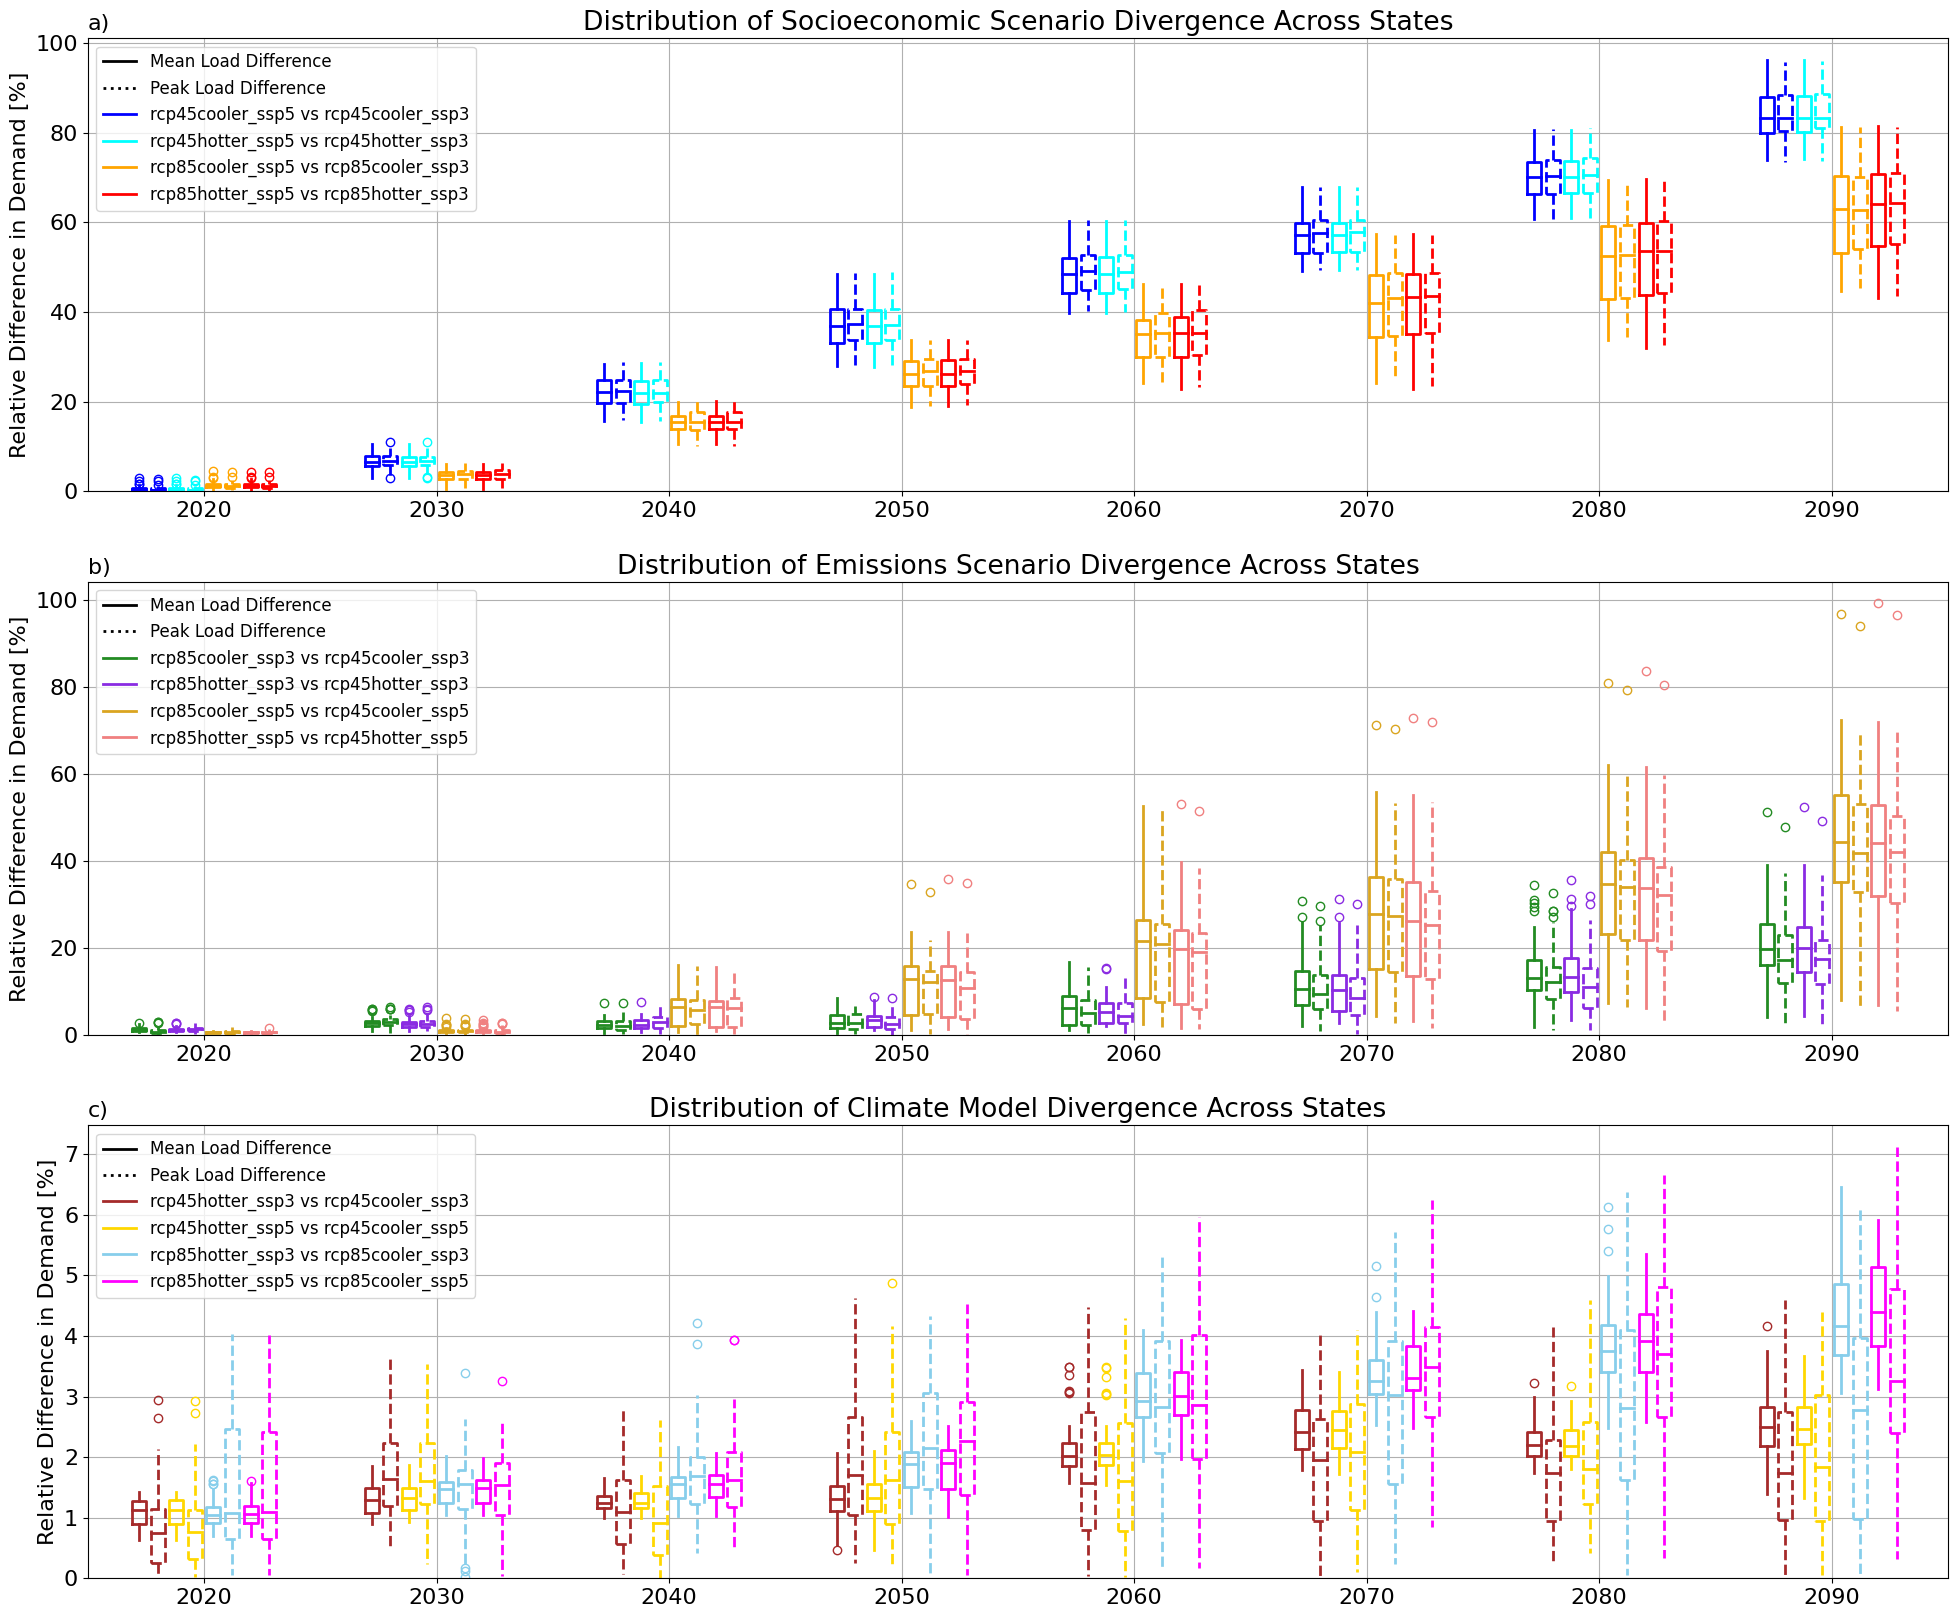

In [19]:
plot_state_difference_box_plots(data_input_dir = data_output_dir, 
                                image_output_dir = image_output_dir, 
                                image_resolution = 300, 
                                save_images = True)


In [20]:
# Define a function to calculate the point of divergence across all scenario combinations by state:
def process_state_point_of_divergence(data_input_dir: str, threshold: int):
    #Initiate a counter to store the results:
    counter = 0;
    output_df = pd.DataFrame()
    
    # Create a list of all files in the input directory:
    list_of_files = glob(f'{data_input_dir}State_Differences*.csv')
       
    # Loop over the list of files and compute the point of divergence for each entity:
    for file in range(len(list_of_files)):
        # Read in the .csv file:
        df = pd.read_csv(list_of_files[file])
    
        # Extract the scenarios from the filename:
        filename = str(os.path.splitext(os.path.basename(list_of_files[file]))[0]).replace('_Versus', '_').replace('State_Differences_', '')
        scenario_one = filename.split('__')[0]
        scenario_two = filename.split('__')[1]
    
        # Make a list of all of the states in the 'df':
        states = df['State'].unique()
         
        # Loop over the states and calculate the point of divergence for each state:
        for i in range(len(states)):
            # Iterate the counter by one:
            counter = counter + 1
            
            # Subset to just the data for the state being processed:
            subset_df = df[df['State'].isin([states[i]])].copy()
            
            # Initiate empty break year and break values:
            mean_break_year = np.nan
            mean_break_value = np.nan
            peak_break_year = np.nan
            peak_break_value = np.nan
                
            # Loop over the rows of the dataframe and check if the mean value in the row exceeds the threshold value:
            for row in range(len(subset_df)-1):
                # If the difference in the year and the following year exceeds the threshold value then stop the loop and output the results:
                if (subset_df['Mean_Rel_Diff_%'].iloc[row] >= threshold) & (subset_df['Mean_Rel_Diff_%'].iloc[row+1] >= threshold):
                    mean_break_year = subset_df['Year'].iloc[row]
                    mean_break_value = subset_df['Mean_Rel_Diff_%'].iloc[row]
                    break
            
            # Loop over the rows of the dataframe and check if the peak value in the row exceeds the threshold value:
            for row in range(len(subset_df)-1):
                # If the difference in the year and the following year exceeds the threshold value then stop the loop and output the results:
                if (subset_df['Peak_Rel_Diff_M2_%'].iloc[row] >= threshold) & (subset_df['Peak_Rel_Diff_M2_%'].iloc[row+1] >= threshold):
                    peak_break_year = subset_df['Year'].iloc[row]
                    peak_break_value = subset_df['Peak_Rel_Diff_M2_%'].iloc[row]
                    break

            # Put the output in a new dataframe:
            output_df.loc[counter, 'State'] = states[i]
            output_df.loc[counter, 'Scenario_One'] = scenario_one
            output_df.loc[counter, 'Scenario_Two'] = scenario_two
            output_df.loc[counter, 'Mean_Break_Year'] = mean_break_year
            output_df.loc[counter, 'Mean_Break_Value_%'] = mean_break_value
            output_df.loc[counter, 'Peak_Break_Year'] = peak_break_year
            output_df.loc[counter, 'Peak_Break_Value_%'] = peak_break_value
            
            # Clean up:
            del subset_df, row, mean_break_year, mean_break_value, peak_break_year, peak_break_value
        
        # Clean up:
        del df, filename, scenario_one, scenario_two, i, states
    
    # Generate the .csv output file name:
    csv_output_filename = os.path.join(data_output_dir, 'State_Divergence_Years_' + str(threshold) + '.csv')
    
    # Write out the dataframe to a .csv file:
    output_df.to_csv(csv_output_filename, sep=',', index=False)
    
    return output_df


In [21]:
output_df = process_state_point_of_divergence(data_input_dir = data_output_dir, 
                                              threshold = 5)

output_df


,State,Scenario_One,Scenario_Two,Mean_Break_Year,Mean_Break_Value_%,Peak_Break_Year,Peak_Break_Value_%
1,Alabama,rcp85hotter_ssp5,rcp85hotter_ssp3,2035.0,11.90,2035.0,12.13
2,Arizona,rcp85hotter_ssp5,rcp85hotter_ssp3,2035.0,8.87,2035.0,11.03
3,Arkansas,rcp85hotter_ssp5,rcp85hotter_ssp3,2030.0,5.22,2030.0,5.49
4,California,rcp85hotter_ssp5,rcp85hotter_ssp3,2035.0,5.49,2035.0,5.18
5,Colorado,rcp85hotter_ssp5,rcp85hotter_ssp3,2035.0,8.39,2035.0,8.93
...,...,...,...,...,...,...,...
584,Virginia,rcp85hotter_ssp5,rcp85cooler_ssp5,NaN,NaN,NaN,NaN
585,Washington,rcp85hotter_ssp5,rcp85cooler_ssp5,NaN,NaN,NaN,NaN
586,West Virginia,rcp85hotter_ssp5,rcp85cooler_ssp5,NaN,NaN,NaN,NaN
587,Wisconsin,rcp85hotter_ssp5,rcp85cooler_ssp5,NaN,NaN,NaN,NaN


In [22]:
# Define a function to plot the maps of year of divergence by state:
def plot_sample_state_divergence_maps(data_input_dir: str, metadata_input_dir: str, threshold: int, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the county shapefile and reassign the 'FIPS' variable as integers:
    states_df = gpd.read_file(os.path.join(metadata_input_dir, 'tl_2022_us_state.shp')).rename(columns={'NAME': 'State'})
       
    # Load in the time series:
    div_df = pd.read_csv(data_input_dir + 'State_Divergence_Years_' + str(threshold) + '.csv') 
    div_df['Null'] = np.nan
     
    # Set the groups of scenarios to plot:
    div_a_one = 'rcp45cooler_ssp5'; div_a_two = 'rcp45cooler_ssp3';
    div_b_one = 'rcp85hotter_ssp3'; div_b_two = 'rcp45hotter_ssp3'; 
    div_c_one = 'rcp85hotter_ssp5'; div_c_two = 'rcp85cooler_ssp5';
        
    # Subset the data to only the three scenarios you want to plot:
    subset_a_df = div_df.loc[(div_df['Scenario_One'] == div_a_one) & (div_df['Scenario_Two'] == div_a_two)]
    subset_b_df = div_df.loc[(div_df['Scenario_One'] == div_b_one) & (div_df['Scenario_Two'] == div_b_two)]
    subset_c_df = div_df.loc[(div_df['Scenario_One'] == div_c_one) & (div_df['Scenario_Two'] == div_c_two)]
    
    # Merge the subset_df and states_df together using state names to join them:
    states_a_df = states_df.merge(subset_a_df, on='State', how='left')
    states_b_df = states_df.merge(subset_b_df, on='State', how='left')
    states_c_df = states_df.merge(subset_c_df, on='State', how='left')

    # Set the colormap:
    colors = plt.get_cmap('YlGnBu', 15)
    
    # Create the cold event figure:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(22,13))
    ax1 = states_a_df.plot(ax=axes[0, 0], column='Peak_Break_Year', cmap=colors, missing_kwds = dict(color="lightgrey"), vmin=2020, vmax=2095, edgecolor='k', linewidth=1)
    ax1.set_xlim(-126.5, -66); ax1.set_xlabel('Longitude'); ax1.set_ylim(24, 50); ax1.set_ylabel('Latitude');
    ax1.set_title('Socioeconomic Scenario Divergence \n ' + div_a_one + ' vs. ' + div_a_two)
    ax1.set_title('a)', loc='left', fontsize=16)
    
    ax2 = states_b_df.plot(ax=axes[1, 0], column='Peak_Break_Year', cmap=colors, missing_kwds = dict(color="lightgrey"), vmin=2020, vmax=2095, edgecolor='k', linewidth=1)
    ax2.set_xlim(-126.5, -66); ax2.set_xlabel('Longitude'); ax2.set_ylim(24, 50); ax2.set_ylabel('Latitude');
    ax2.set_title('Climate Scenario Divergence \n ' + div_b_one + ' vs. ' + div_b_two)
    ax2.set_title('b)', loc='left', fontsize=16)
    
    ax3 = states_c_df.plot(ax=axes[1, 1], column='Peak_Break_Year', cmap=colors, missing_kwds = dict(color="lightgrey"), vmin=2020, vmax=2095, edgecolor='k', linewidth=1)
    ax3.set_xlim(-126.5, -66); ax3.set_xlabel('Longitude'); ax3.set_ylim(24, 50); ax3.set_ylabel('Latitude');
    ax3.set_title('Climate Model Divergence \n ' + div_c_one + ' vs. ' + div_c_two)
    ax3.set_title('c)', loc='left', fontsize=16)
    
    ax4 = states_b_df.plot(ax=axes[0, 1], column='Null', cmap=colors, missing_kwds = dict(color="white"), vmin=2020, vmax=2095, edgecolor='k', linewidth=0, 
                           legend=True, legend_kwds={'label': ('First Year in Which Peak Load Differences Exceed ' + str(threshold) + '%'), 'orientation': 'horizontal'})
    ax4.set_xticks([]), ax4.set_yticks([]), ax4.axis('off')
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('Maps.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


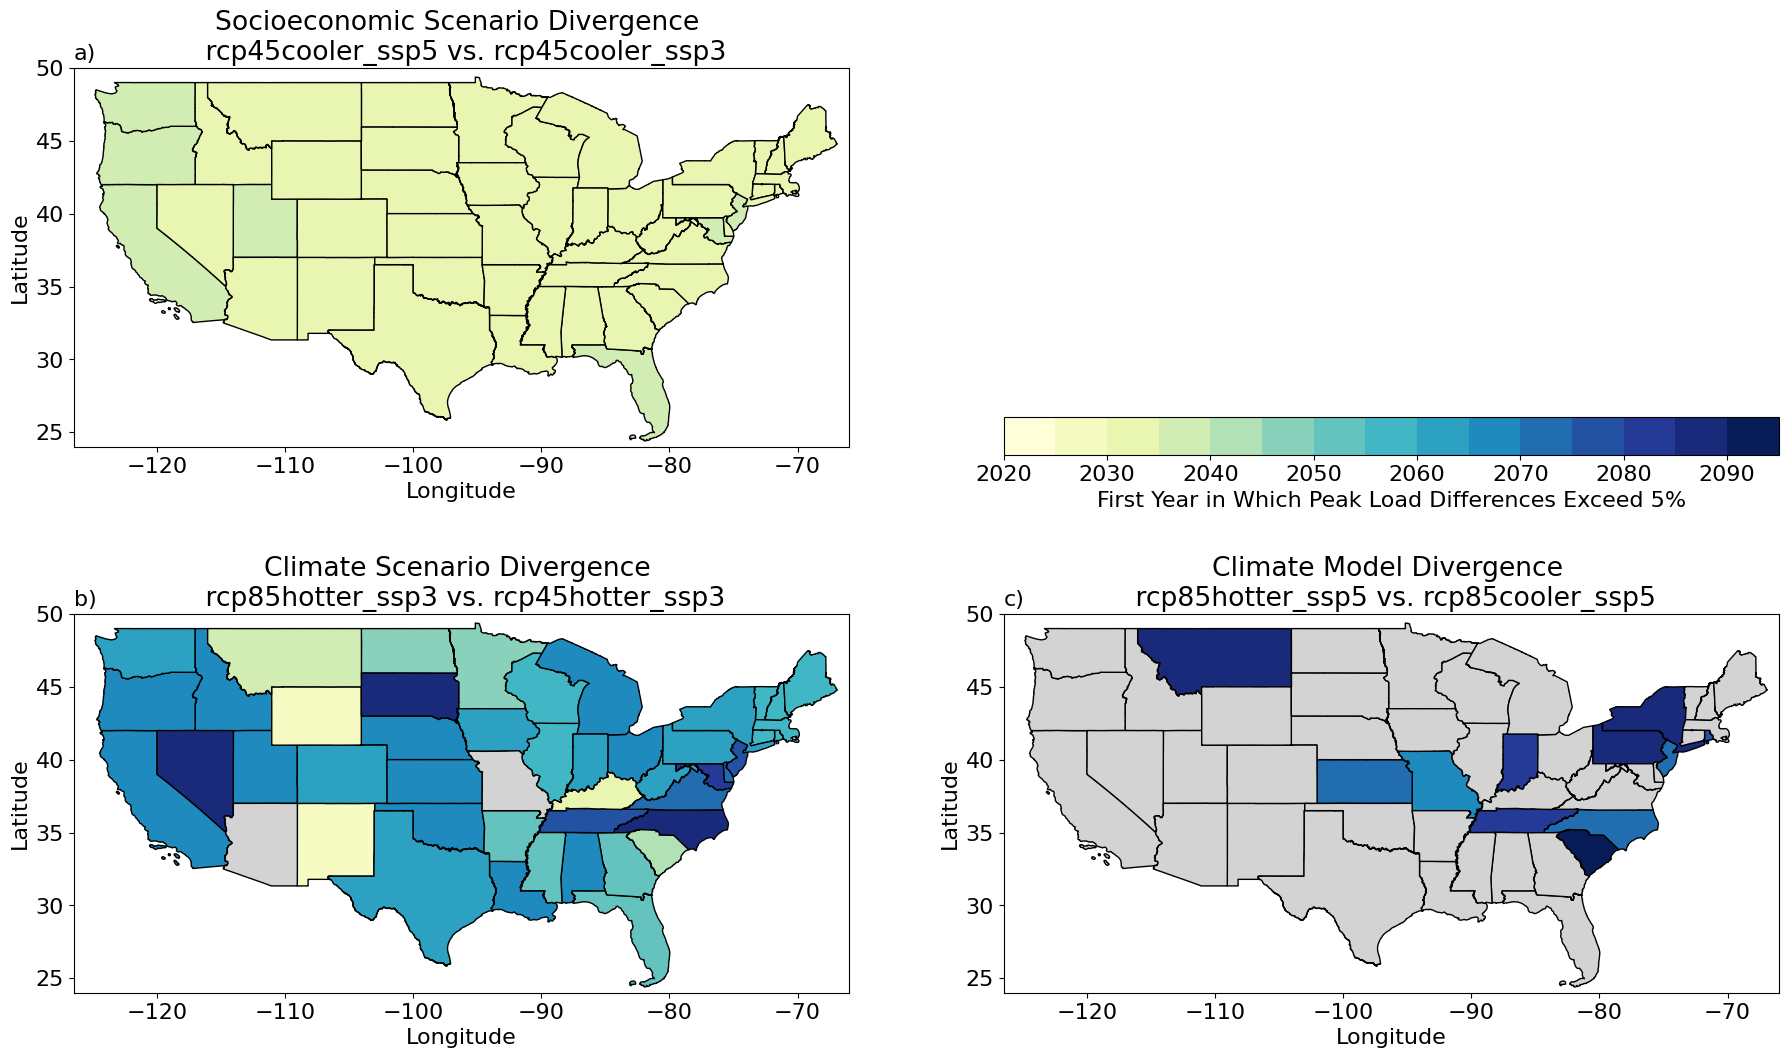

In [23]:
plot_sample_state_divergence_maps(data_input_dir = data_output_dir, 
                                  metadata_input_dir = metadata_input_dir,
                                  threshold = 5,
                                  image_output_dir = image_output_dir, 
                                  image_resolution = 300, 
                                  save_images = True)


In [24]:
# Define a function to plot the maps of year of divergence by state:
def plot_state_divergence_maps(data_input_dir: str, metadata_input_dir: str, scenario_one: str, scenario_two: str, threshold: int, image_output_dir: str, image_resolution: int, save_images=False):
    
    # Read in the county shapefile and reassign the 'FIPS' variable as integers:
    states_df = gpd.read_file(os.path.join(metadata_input_dir, 'tl_2022_us_state.shp')).rename(columns={'NAME': 'State'})
       
    # Load in the time series:
    div_df = pd.read_csv(data_input_dir + 'State_Divergence_Years_' + str(threshold) + '.csv') 
    div_df['Null'] = np.nan
     
    # Subset the data to only the three scenarios you want to plot:
    subset_df = div_df.loc[(div_df['Scenario_One'] == scenario_one) & (div_df['Scenario_Two'] == scenario_two)]
    
    # Merge the subset_df and states_df together using state names to join them:
    states_a_df = states_df.merge(subset_df, on='State', how='left')
   
    # Set the colormap:
    colors = plt.get_cmap('YlGnBu', 15)
    
    # Create the figure:
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(25,13))
    
    # Plot the first year in which the mean load differences exceed 5%:
    ax1 = states_a_df.plot(ax=axes[0], column='Mean_Break_Year', cmap=colors, missing_kwds = dict(color="lightgrey"), vmin=2020, vmax=2095, edgecolor='k', linewidth=1,
                           legend=True, legend_kwds={'label': ('Mean Load Divergence Year'), 'orientation': 'vertical'})
    ax1.set_xlim(-126.5, -66);
    ax1.set_xlabel('Longitude', fontsize=14);
    ax1.set_ylim(24, 50);
    ax1.set_ylabel('Latitude', fontsize=14);
    ax1.set_title(('Mean Load Divergence: ' + scenario_one + ' vs. ' + scenario_two), fontsize=16)
    ax1.set_title('a)', loc='left', fontsize=16)
    
    # Plot the first year in which the peak load differences exceed 5%:
    ax2 = states_a_df.plot(ax=axes[1], column='Peak_Break_Year', cmap=colors, missing_kwds = dict(color="lightgrey"), vmin=2020, vmax=2095, edgecolor='k', linewidth=1,
                           legend=True, legend_kwds={'label': ('Peak Load Divergence Year'), 'orientation': 'vertical'})
    ax2.set_xlim(-126.5, -66);
    ax2.set_xlabel('Longitude', fontsize=14);
    ax2.set_ylim(24, 50);
    ax2.set_ylabel('Latitude', fontsize=14);
    ax2.set_title(('Peak Load Divergence: ' + scenario_one + ' vs. ' + scenario_two), fontsize=16)
    ax2.set_title('b)', loc='left', fontsize=16)
    
    # If the "save_images" flag is set to true then save the plot to a .png file:
    if save_images == True:
       filename = ('Divergence_Maps_' + scenario_one + '_vs_' + scenario_two + '.png')
       plt.savefig(os.path.join(image_output_dir, filename), dpi=image_resolution, bbox_inches='tight', facecolor='white')


In [ ]:
# Set the groups of scenarios to plot:
#scenario_one = 'rcp45cooler_ssp5'; scenario_two = 'rcp45cooler_ssp3';
#scenario_one = 'rcp45hotter_ssp5'; scenario_two = 'rcp45hotter_ssp3';
#scenario_one = 'rcp85cooler_ssp5'; scenario_two = 'rcp85cooler_ssp3';
#scenario_one = 'rcp85hotter_ssp5'; scenario_two = 'rcp85hotter_ssp3';
#scenario_one = 'rcp85cooler_ssp3'; scenario_two = 'rcp45cooler_ssp3'; 
#scenario_one = 'rcp85hotter_ssp3'; scenario_two = 'rcp45hotter_ssp3'; 
scenario_one = 'rcp85cooler_ssp5'; scenario_two = 'rcp45cooler_ssp5'; 
#scenario_one = 'rcp85hotter_ssp5'; scenario_two = 'rcp45hotter_ssp5';
#scenario_one = 'rcp45hotter_ssp3'; scenario_two = 'rcp45cooler_ssp3'; 
#scenario_one = 'rcp45hotter_ssp5'; scenario_two = 'rcp45cooler_ssp5'; 
#scenario_one = 'rcp85hotter_ssp3'; scenario_two = 'rcp85cooler_ssp3'; 
#scenario_one = 'rcp85hotter_ssp5'; scenario_two = 'rcp85cooler_ssp5';
    
plot_state_divergence_maps(data_input_dir = data_output_dir, 
                           metadata_input_dir = metadata_input_dir,
                           scenario_one = scenario_one, 
                           scenario_two = scenario_two,
                           threshold = 5,
                           image_output_dir = image_output_dir, 
                           image_resolution = 150, 
                           save_images = True)
